<a href="https://colab.research.google.com/github/honkskillet/ILO_B_Reader/blob/main/CNN_NIH_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NIH CXR Database Image Classifier using InceptionV3 and a Neral Network Classifier

In [ ]:
"""
Feature Extractor: NN pretained on InceptionV3
Output layer(s): Single Dense laeyr - traditional machine learning classifiers
Inspired by Sreenivas Bhattiprolu's classifier of similar approach
https://github.com/bnsreenu/python_for_microscopists/blob/master/158_classification_CNN_RF.py
"""
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
import tensorflow as tf
import seaborn as sns
from sklearn import preprocessing, metrics

In [ ]:
#UTILITY FUCTION FOR TIME STAMPS
import calendar, time
from datetime import datetime
def getTimeStamp():
  current_GMT = time.gmtime()  # Current GMT time in a tuple format
  ts = calendar.timegm(current_GMT)   # ts stores timestamp
  date_time = datetime.fromtimestamp(ts)
  return date_time.strftime("%m%d-%H%M%S")  # convert timestamp to string in dd-mm-yyyy HH:MM:SS

In [ ]:
# SHOW US WHAT YAH GOT
import sys
print(f"GPU: {tf.config.list_physical_devices('GPU')}  ")
print(f"CPU: {tf.config.list_physical_devices('CPU')}  ")
print(f"Python {sys.version}\nTensorflow{tf.__version__}")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]  
CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]  
Python 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Tensorflow2.8.2
Sun Aug 28 04:06:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      2MiB / 16160MiB |      0%      Default |
|                       

In [ ]:
# If running on google colab, mount colab drive
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print('Not running on CoLab')

Mounted at /content/drive


In [ ]:
WORKING_DIR_TS = os.getcwd()
WORKING_DIR_TS += '/'
if 'google.colab' in str(get_ipython()): #if working on google colab google colab
  WORKING_DIR_TS = '/content/' #this is where files actually reside on google colab (that is on a mounted google drive)
WORKING_DIR_TS

'/content/drive/MyDrive/'

In [ ]:
# DEFINE CONSTANSTS
SIZE = 768  #Resize images, note original input shape for InceptionV3 is (299,299,3)
BATCH_SIZE = 32 # AUTOTUNE = tf.data.AUTOTUNE
VALIDATION_SPLIT = 0.2
EPOCHS=50

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    WORKING_DIR_TS +'NIH_1stPA_Norm_Fib',
    validation_split=0.2,
    subset="training",
    seed=38,
    image_size=(SIZE,SIZE),
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    WORKING_DIR_TS +'NIH_1stPA_Norm_Fib',
    validation_split=0.2,
    subset="validation",
    seed=38,
    # shuffle=False,
    image_size=(SIZE,SIZE),
    batch_size=BATCH_SIZE,
)
##
CLASS_NAMES=train_ds.class_names
## SETUP FOR CACHE AND BATCH AUTOTUNING

# AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=BATCH_SIZE)
# train_ds = train_ds.cache() #.prefetch(buffer_size=BATCH_SIZE)
# val_ds = val_ds.cache() #.prefetch(buffer_size=BATCH_SIZE)

Found 7008 files belonging to 2 classes.
Using 5607 files for training.
Found 7008 files belonging to 2 classes.
Using 1401 files for validation.


In [ ]:
num_fibrosis = len(glob.glob(WORKING_DIR_TS +'NIH_1stPA_Norm_Fib/Fibrosis/*.png'))
num_normal = len(glob.glob(WORKING_DIR_TS +'NIH_1stPA_Norm_Fib/No Finding/*.png'))
perc_for_val =.2
oversample_multiplier = 5
num_fibrosis_in_val = int(num_fibrosis*perc_for_val)
oversample_count = num_fibrosis_in_val*oversample_multiplier
if oversample_count > num_normal:
  raise ValueError(f'oversample # - {oversample_count} - exceeds count of majority class - {num_normal}')

full_ds = tf.keras.utils.image_dataset_from_directory(
    WORKING_DIR_TS +'NIH_1stPA_Norm_Fib',
    image_size=(SIZE,SIZE),
    batch_size= None,
    # shuffle=False
)

full_ds.cardinality()

# # full_ds =full_ds.shuffle(9999999,s)

Found 7008 files belonging to 2 classes.


<tf.Tensor: shape=(), dtype=int64, numpy=7008>

In [ ]:
from numpy.ma.core import concatenate
# fibrosis_ds = full_ds.filter(lambda x, y: print(y),  tf.cast(y, tf.bool)  )
fibrosis_ds = full_ds.filter(lambda x, y:  tf.equal(y, 0) ) # y == 0 for fibrosis
normal_ds = full_ds.filter(lambda x, y:  tf.equal(y, 1) ) # y == 1 for normal
# Let's take 20% of fibrosis images, and an equal number of normals, for our validation dataset
val_ds = fibrosis_ds.take( num_fibrosis_in_val )
val_ds = val_ds.concatenate( normal_ds.take( num_fibrosis_in_val ) )
val_ds = val_ds.batch(BATCH_SIZE)
# Make the traing set
train_ds = fibrosis_ds.skip(num_fibrosis_in_val).take(num_fibrosis - num_fibrosis_in_val)
train_ds = train_ds.repeat( oversample_multiplier )
train_ds = train_ds.concatenate( normal_ds.skip(num_fibrosis_in_val).take(oversample_count) )
train_ds = train_ds.shuffle(oversample_count*2)
train_ds = train_ds.batch(BATCH_SIZE)
# fibrosis_ds.cardinality()
i=0
for _, _ in train_ds:
    # predictions.append(np.argmax(model(x), axis=-1))
    # labels.append(y.numpy())
    i+=1
    # print(y)
    # break
i


KeyboardInterrupt: ignored

In [ ]:
val_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=-2>

#### TFDS: GET DATA FROM FILES with TF DATASETS

In [ ]:

## GET THE ACTUAL LABELS OF THE VALIDATION SETS, in Os and 1s
true_categories = tf.concat([y for x, y in val_ds], axis=0)
 

In [ ]:
import numpy
true_categories.numpy()
numpy.unique(true_categories.numpy(), return_counts=True)

(array([0, 1], dtype=int32), array([ 119, 1282]))

['Fibrosis', 'No Finding']

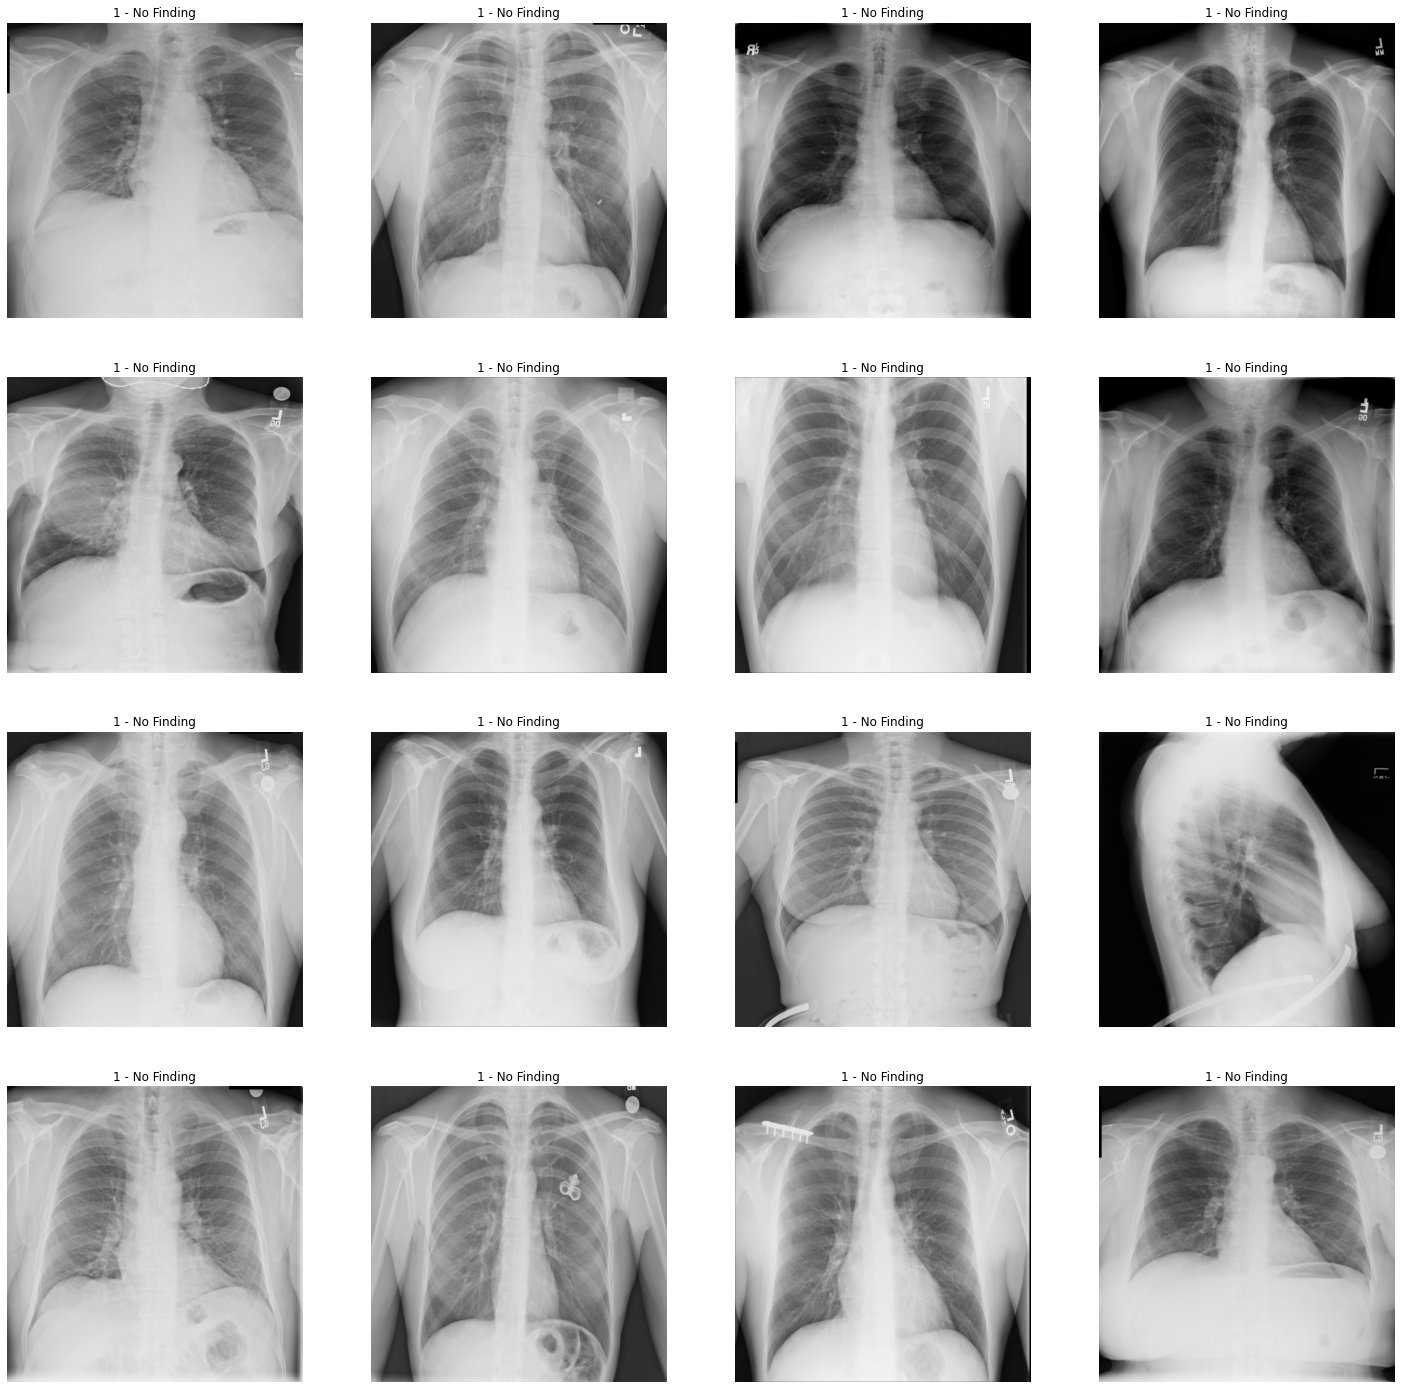

In [ ]:
#PLOT SOME IMAGES
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{labels[i]} - " + CLASS_NAMES[labels[i]])
        plt.axis("off")
CLASS_NAMES

### Calculate Class Weights From Folder/File Structure

In [ ]:
#CLASS WEIGHTS AND SAMPLE COUNT

#image_folder_path = 'dicom/NIH_1stPA_Norm_Fib'
image_folder_path = '/content/drive/MyDrive/NIH_1stPA_Norm_Fib'
image_count= []
for dir in CLASS_NAMES:
    print(f"{image_folder_path}/{dir}")
    image_count.append(len(glob.glob(f"{image_folder_path}/{dir}/*.png")))
class_weights = {index: max(image_count)/count for index, count in enumerate(image_count)} # convert to a dictionary
TOTAL_SAMPLES=sum(image_count)
class_weights,  TOTAL_SAMPLES, image_count

/content/drive/MyDrive/NIH_1stPA_Norm_Fib/Fibrosis
/content/drive/MyDrive/NIH_1stPA_Norm_Fib/No Finding


({0: 10.001569858712715, 1: 1.0}, 7008, [637, 6371])

#### UNDERSAMPLING

In [ ]:
# for line in train_ds.take(1):
#     print(len(line))
#     print(line[:][1])
# # initial_dist = list(np.divide(image_count,TOTAL_SAMPLE))
# initial_dist = [0.09,0.91]
# target_dist = [0.5, 0.5]
# # print(initial_dist)
# # initial_dist,target_dist
# # def garbage(image_data,image_label):
# #     print(image_data)
# #     print(tf.squeeze( image_label)[0])
# #     return tf.squeeze( image_label)
# resampled_dataset = train_ds.rejection_resample(
#    class_func=lambda image_data,image_label: tf.squeeze( image_label),
#    initial_dist=initial_dist,
#    target_dist=target_dist
#    )
# resampled_dataset = resampled_dataset.map(
#     lambda class_func_result, data: data)

In [ ]:
# for line in train_ds.take(1):
#     # print(len(line))
#     print(line[:][1])

TRANSFER LEARNING WITH BUILT IN IMAGE RESCALING

In [ ]:
# define our transfer learning base model
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,  input_shape=(SIZE,SIZE,3), pooling='max')
base_model.trainable = False

# Create a model and train it on the augmented image data
inputs = tf.keras.Input(shape=(SIZE, SIZE, 3))
intermediate = tf.keras.layers.Rescaling(1.0 / 255)(inputs) 
intermediate = base_model(intermediate)

### Create a simple final dense NN layer
intermediate = tf.keras.layers.Dense(512, activation='relu')(intermediate)
# intermediate = tf.keras.layers.Dropout(0.1)(intermediate)
outputs = tf.keras.layers.Dense( len(CLASS_NAMES), activation = tf.keras.activations.softmax)(intermediate)
### CREATE OUR FINAL MODEL
model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768, 768, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 768, 768, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 22,852,898
Trainable params: 1,050,114
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# COMPILING THE CNN
model.compile(
  optimizer = 'adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#  logits=TrUe /// loss = 'hinge', 
  metrics = ['accuracy']) #'sparse_categorical_crossentropy'

In [ ]:
# SAVE CHECKPOINTS
# generate path wehere you want to save your checkpoints
checkpoint_path = f"checkpoints/{getTimeStamp()}_weights.h5"
# define a callback that will save the model weights after every epoch 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  #save_weights_only=True,
  monitor='accuracy',
  mode='max',
  verbose=1,
  save_best_only=True)

In [ ]:
#Train the CNN model, note:batch size is set by dataset 
print(f"IMAGE SIZE: {SIZE}x{SIZE}px")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS, 
  #steps_per_epoch=steps_per_epoch,
  #validation_steps = int(steps_per_epoch*VALIDATION_SPLIT),
  class_weight=class_weights,
  callbacks=[model_checkpoint_callback])

IMAGE SIZE: 768x768px
Epoch 1/50
176/176 [==============================] - ETA: 0s - loss: 4.0810 - accuracy: 0.5613
Epoch 1: accuracy improved from -inf to 0.56126, saving model to checkpoints/0827-030301_weights.h5
176/176 [==============================] - 171s 825ms/step - loss: 4.0810 - accuracy: 0.5613 - val_loss: 0.2659 - val_accuracy: 0.9051
Epoch 2/50
176/176 [==============================] - ETA: 0s - loss: 1.7539 - accuracy: 0.6358
Epoch 2: accuracy improved from 0.56126 to 0.63581, saving model to checkpoints/0827-030301_weights.h5
176/176 [==============================] - 189s 1s/step - loss: 1.7539 - accuracy: 0.6358 - val_loss: 0.2796 - val_accuracy: 0.8922
Epoch 3/50
176/176 [==============================] - ETA: 0s - loss: 1.5107 - accuracy: 0.6688
Epoch 3: accuracy improved from 0.63581 to 0.66881, saving model to checkpoints/0827-030301_weights.h5
176/176 [==============================] - 193s 1s/step - loss: 1.5107 - accuracy: 0.6688 - val_loss: 0.2739 - val_ac

In [ ]:
## continue fitting the model
if(False): ##I don't want this to run noramlly
  # load model weights from file
  new_model = tf.keras.models.load_model(checkpoint_path)
  # generate a new path wehere you want to save your checkpoints
  checkpoint_path = f"checkpoints/{getTimeStamp()}_weights.h5"
  # define a callback wutg the new path name
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)
  ##RESTART TRAINING
  history = new_model.fit( 
    train_ds,
    validation_data=val_ds,
    epochs= EPOCHS, 
    #steps_per_epoch=steps_per_epoch,
    #validation_steps = int(steps_per_epoch*VALIDATION_SPLIT),
    class_weight=class_weights,
    callbacks=[model_checkpoint_callback])
# load the model
# model= tf.keras.models.load_model(checkpoint_path) ## loads most successful version of the fit

##### PLOT RESULTS

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


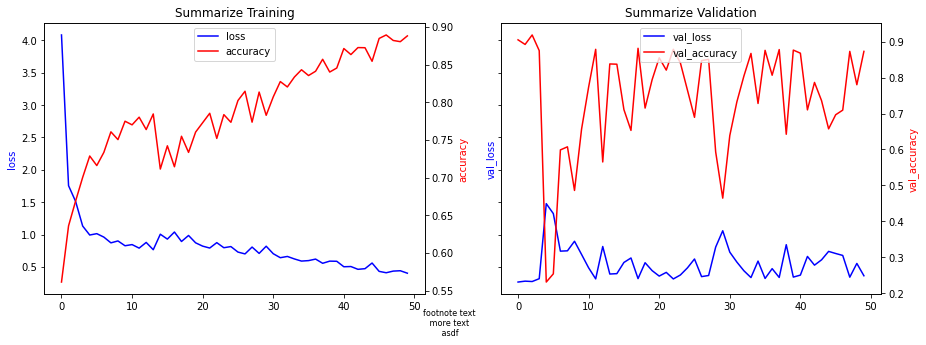

In [ ]:
print(history.history.keys())
# summarize training
fig, (ax1,bx1), = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
l1, = ax1.plot(history.history['loss'], color='blue') 
ax2 = ax1.twinx()
l2, = ax2.plot(history.history['accuracy'], color='red')
ax1.set_ylabel('loss' , color='blue')
ax2.set_ylabel('accuracy', color='red' )
plt.legend([l1, l2], ["loss","accuracy" ], loc="upper center")
plt.xlabel('epochs')
plt.title('Summarize Training')
plt.figtext(0.5, 0.01, 'footnote text\n more text \n asdf', horizontalalignment='center', fontsize=8)
# plt.show()

# summarize validation
# fig, ax1 = plt.subplots()
l1, = bx1.plot(history.history['val_loss'], color='blue') 
bx2 = bx1.twinx()
l2, = bx2.plot(history.history['val_accuracy'], color='red')
bx1.set_ylabel('val_loss' , color='blue')
bx2.set_ylabel('val_accuracy', color='red' )
plt.legend([l1, l2], ["val_loss","val_accuracy" ], loc="upper center")
plt.xlabel('epochs')
plt.title('Summarize Validation')
plt.show()



Accuracy =  0.8729478943611706
tf.Tensor(
[[  33   86]
 [  92 1190]], shape=(2, 2), dtype=int32)


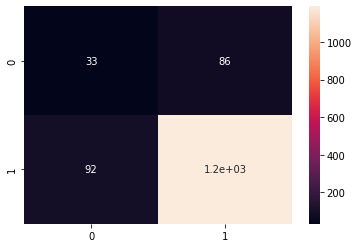

In [ ]:
predictions = []
labels = []
for x, y in val_ds:
    predictions.append(np.argmax(model(x), axis=-1))
    labels.append(y.numpy())

predictions = np.concatenate(predictions, axis=0)
labels = np.concatenate(labels, axis=0)
accuracy = metrics.accuracy_score(labels,predictions)
print ("Accuracy = ", accuracy)
cm = tf.math.confusion_matrix(labels,predictions)
print(cm)
heatmap =sns.heatmap(cm, annot=True)

In [ ]:
# predictions = model.predict(val_ds, verbose=2 ) 
# flattened_predictions =  predictions.argmax(axis=1)
# #Print overall accuracy
# accuracy = metrics.accuracy_score(true_categories, flattened_predictions)
# print ("Accuracy = ", accuracy)



In [ ]:
cm = tf.math.confusion_matrix(labels,predictions)
print(cm)
heatmap =sns.heatmap(cm, annot=True)

##### EXTRACT FEATURES USING THE PRETRAINED CNN

In [ ]:
import random
ds1 = tf.data.Dataset.from_tensor_slices([0,1,2,3,4,5,6,7,8,9])
ds2 = tf.data.Dataset.from_tensor_slices([101,100]).repeat(5)

choice_dataset = tf.data.Dataset.range(2).repeat(20)
result = tf.data.Dataset.choose_from_datasets([ds1, ds2], choice_dataset)

list(result.shuffle(20).take(20).as_numpy_iterator())

# random.choices([0,1], weights=[5,1],k=20)

In [ ]:
# from sklearn.metrics import confusion_matrix
#Confusion Matrix - verify accuracy of each class
cm = metrics.confusion_matrix(true_categories, flattened_predictions)
#print(cm)
heatmap =sns.heatmap(cm, annot=True)

NameError: ignored

In [ ]:

#Save confusion matrix
heatmap.get_figure().savefig(f"confusion_matrices/{getTimeStamp()}_VGG16-RF_cats{cm.shape[0]}-{MAX_NUMBER_OF_EACH_FINDING}-{NUMBER_OF_EACH_FINDING_RESERVED_FOR_TESTING}_size{SIZE}_acc{round(accuracy,2)}.png")

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = label_encoder.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])